In [14]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scienceplots
from scipy.stats import norm

plt.style.use('science')

backup_root_dir = 'archive/tennis_abstract_dfs copy'
df_root_dir = 'tennis_abstract_dfs'
save_root_dir = backup_root_dir
big_df_name = 'big_df.pkl'
surfs = ['Clay', 'Grass', 'Hard']
poly3d_coeefs = [-3.51591704,  5.26301386, -0.79325641,  0.02302555]
swr_baseline = 63.5
rwr_baseline = 36.5


In [15]:
all_names = []
for file in tqdm(os.listdir(df_root_dir)):
    name = file[:-4]
    all_names.append(name)

print(len(all_names))
    

top_200_names = []
for file in tqdm(os.listdir(df_root_dir)):
    name = file[:-4]
    file_name = f'{df_root_dir}/{file}'
    p_df = pd.read_pickle(f'{df_root_dir}/{file}')
    latest_rank = p_df['rank'].iloc[-1]
    if latest_rank:
        latest_rank = int(latest_rank)
        if latest_rank < 200:
            top_200_names.append(name)
len(top_200_names)

100%|██████████| 380/380 [00:00<00:00, 379304.03it/s]


380


100%|██████████| 380/380 [00:00<00:00, 1036.44it/s]


195

In [16]:
def first_values(row, player, shot, c):
    gg_swr = 0.64
    gb_swr = 0.74
    gb_rwr = 0.5
    gb_wr = 0.95
    good_ps = good_po = 2220
    rank_drop_rate = 120 
    good_pr = good_ps - c*math.log10(gg_swr/(1-gg_swr))
    bad_pr = good_ps - c*math.log10(gb_swr/(1-gb_swr))
    bad_ps = good_pr - c*math.log10(gb_rwr/(1-gb_rwr))
    bad_po = good_po - c*math.log10(gb_wr/(1-gb_wr))
    
    rnk = row['rank'] if player == 'p' else row['orank']
    if shot == 'r':
        return bad_pr + (good_pr - bad_pr) * np.exp(-int(rnk)/rank_drop_rate) if rnk else bad_pr
    elif shot == 'o':
        return bad_po + (good_po - bad_po) * np.exp(-int(rnk)/rank_drop_rate) if rnk else bad_po
    else:
        return bad_ps + (good_ps - bad_ps) * np.exp(-int(rnk)/rank_drop_rate) if rnk else bad_ps

    
def first_values_from_last(df, ranking_name):
    assert ranking_name in df.columns, f"Ranking name '{ranking_name}' not found in DataFrame columns."
    last_row = df.iloc[-1]
    return last_row[ranking_name]

In [17]:
def restore_df():
    backup_path = f'{backup_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(backup_path)
    pd.to_pickle(og, file_path)


def save_df():
    save_path = f'{save_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(file_path)
    pd.to_pickle(og, save_path)

def backup_df():
    save_path = f'{backup_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(file_path)
    pd.to_pickle(og, save_path)

# save_df()
# backup_df()
restore_df()

big_df = pd.read_pickle(big_df_name)

all_names = set(big_df['formatted_player']).union(big_df['formatted_opp'])
all_names = list(all_names)


100%|██████████| 195/195 [00:00<00:00, 401.93it/s]


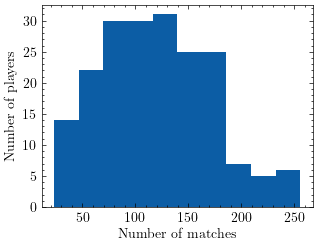

Mean number of matches per player: 119.64
Minimum number of matches per player: 23.00
Minimum number of matches per player: 256.00


100%|██████████| 195/195 [00:00<00:00, 359.37it/s]


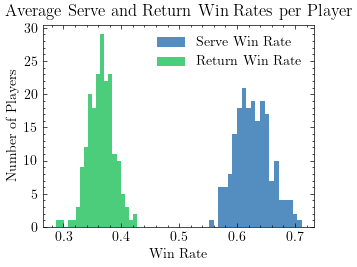

Mean SWR: 0.63, Min SWR: 0.55, Max SWR: 0.71
Mean RWR: 0.37, Min RWR: 0.29, Max RWR: 0.43


In [18]:
num_matches = []
for name in tqdm(all_names):
    p_df = big_df[big_df['formatted_player'] == name]
    o_df = big_df[big_df['formatted_opp'] == name]
    num_matches.append(p_df.shape[0] + o_df.shape[0])

plt.hist(num_matches, bins=10)
plt.xlabel('Number of matches')
plt.ylabel('Number of players')
plt.show()

print(f"Mean number of matches per player: {np.mean(num_matches):.2f}")
print(f"Minimum number of matches per player: {np.min(num_matches):.2f}")
print(f"Minimum number of matches per player: {np.max(num_matches):.2f}")

avg_swr = []
avg_rwr = []
for name in tqdm(all_names):
    p_df = big_df[big_df['formatted_player'] == name]
    o_df = big_df[big_df['formatted_opp'] == name]
    # Serve win rate: as player, use serve_win_rate; as opp, use 1 - return_win_rate
    swr = pd.concat([
        p_df['serve_win_rate'],
        1 - o_df['return_win_rate']
    ])
    # Return win rate: as player, use return_win_rate; as opp, use 1 - serve_win_rate
    rwr = pd.concat([
        p_df['return_win_rate'],
        1 - o_df['serve_win_rate']
    ])
    avg_swr.append(swr.mean())
    avg_rwr.append(rwr.mean())

plt.hist(avg_swr, bins=20, alpha=0.7, label='Serve Win Rate')
plt.hist(avg_rwr, bins=20, alpha=0.7, label='Return Win Rate')
plt.xlabel('Win Rate')
plt.ylabel('Number of Players')
plt.legend()
plt.title('Average Serve and Return Win Rates per Player')
plt.show()

print(f"Mean SWR: {np.mean(avg_swr):.2f}, Min SWR: {np.min(avg_swr):.2f}, Max SWR: {np.max(avg_swr):.2f}")
print(f"Mean RWR: {np.mean(avg_rwr):.2f}, Min RWR: {np.min(avg_rwr):.2f}, Max RWR: {np.max(avg_rwr):.2f}")

In [19]:
for i in big_df.columns:
    print(i)

date
tourn
surf
level
win/loss
rank
seed
entry
round
score
max_num_of_sets
opp
orank
oseed
oentry
ohand
obday
oheight
ocountry
oactive
time_minutes
aces
dfs
service_pts
first_serves_in
first_serves_won
second_serves_won
service_games
break_points_saved
break_points_faced
oaces
odfs
oservice_pts
ofirst_serves_in
ofirst_serves_won
osecond_serves_won
oservice_games
obreak_points_saved
obreak_points_faced
obackhand
chartlink
pslink
whserver
matchid
wh
roundnum
matchnum
oforeign_key
formatted_opp
round_val
serve_win_rate
overall_win_rate
return_win_rate
first_serve_in_rate
first_return_in_rate
first_serve_win_rate
second_serve_win_rate
first_return_win_rate
second_return_win_rate
prev_10_mean_serve_win_rate
prev_10_median_serve_win_rate
prev_10_mean_return_win_rate
prev_10_median_return_win_rate
prev_10_mean_first_serve_win_rate
prev_10_median_first_serve_win_rate
prev_10_mean_first_serve_in_rate
prev_10_median_first_serve_in_rate
prev_10_mean_first_return_in_rate
prev_10_median_first_retur

In [20]:
calls = {'depth': 0}
def update_player(player, opp_progress=None):
    calls['depth'] += 1
    # print(f"depth: {calls['depth']}")
    starting_index = player_progresses[player]
    date, rnd, opp = big_df.loc[starting_index, ['date', 'round', 'formatted_opp' if big_df.loc[starting_index, 'formatted_player'] == player else 'formatted_player']]
    # print(f'player: {player} starting at {date}_{rnd}_{opp}') 
    p_df = big_df[(big_df['formatted_player'] == player) | (big_df['formatted_opp'] == player)]

    p_df = p_df.loc[starting_index:]

    for i in p_df.index:
        match = big_df.iloc[i]
        home_away = 'home'
        if match['formatted_player'] != player:
            assert match['formatted_opp'] == player
            home_away = 'away'
        opp = match['formatted_opp'] if home_away == 'home' else match['formatted_player']
        if opp_progress is not None and i >= opp_progress:
            calls['depth'] -= 1
            # print(f"depth: {calls['depth']}")
            return
        surf = match['surf'][0].lower()
        update_player(opp, player_progresses[player])
        elo_suffix = 'o' if home_away == 'away' else ''
        elo_suffix_o = 'o' if home_away == 'home' else ''

        p_s, p_r, p_o, o_s, o_r, o_o = match[f'{elo_suffix}R_{surf}_s'], match[f'{elo_suffix}R_{surf}_r'], match[f'{elo_suffix}R_{surf}_o'], match[f'{elo_suffix_o}R_{surf}_s'], match[f'{elo_suffix_o}R_{surf}_r'], match[f'{elo_suffix_o}R_{surf}_o']  
        Q_ps, Q_pr, Q_po, Q_os, Q_or, Q_oo = 10**(p_s/c), 10**(p_r/c),10**(p_o/c), 10**(o_s/c), 10**(o_r/c), 10**(o_o/c)
        E_s, E_r, E_o = Q_ps/(Q_ps + Q_or), Q_pr/(Q_pr + Q_os), Q_po/(Q_po + Q_oo)

        p_os, p_or, p_oo, o_os, o_or, o_oo = match[f'{elo_suffix}R_o_s'], match[f'{elo_suffix}R_o_r'],match[f'{elo_suffix}R_o_o'], match[f'{elo_suffix_o}R_o_s'], match[f'{elo_suffix_o}R_o_r'], match[f'{elo_suffix_o}R_o_o']  
        Q_ops, Q_opr, Q_opo, Q_oos, Q_oor, Q_ooo = 10**(p_os/c), 10**(p_or/c), 10**(p_oo/c), 10**(o_os/c), 10**(o_or/c), 10**(o_oo/c)
        E_os, E_or, E_oo = Q_ops/(Q_ops + Q_oor), Q_opr/(Q_opr + Q_oos), Q_opo/(Q_opo + Q_ooo)

        Q_psm, Q_prm, Q_pom, Q_osm, Q_orm, Q_oom = 10**((p_s + p_os)/(2*c)), 10**((p_r + p_or)/(2*c)), 10**((p_o + p_oo)/(2*c)), 10**((o_s + o_os)/(2*c)), 10**((o_r + o_or)/(2*c)), 10**((o_o + o_oo)/(2*c))
        E_ms, E_mr, E_mo = Q_psm/(Q_psm + Q_orm), Q_prm/(Q_prm + Q_osm), Q_pom/(Q_pom + Q_oom)

        if home_away == 'home':
            big_df.loc[i, 'E_s'] = E_s
            big_df.loc[i, 'E_r'] = E_r
            big_df.loc[i, 'E_o'] = E_o
            big_df.loc[i, 'E_os'] = E_os
            big_df.loc[i, 'E_or'] = E_or
            big_df.loc[i, 'E_oo'] = E_oo
            big_df.loc[i, 'E_ms'] = E_ms
            big_df.loc[i, 'E_mr'] = E_mr
            big_df.loc[i, 'E_mo'] = E_mo
        else:
            big_df.loc[i, 'E_s'] = 1-E_r
            big_df.loc[i, 'E_r'] = 1-E_s
            big_df.loc[i, 'E_o'] = 1-E_o
            big_df.loc[i, 'E_os'] = 1-E_or
            big_df.loc[i, 'E_or'] = 1-E_os
            big_df.loc[i, 'E_oo'] = 1-E_oo
            big_df.loc[i, 'E_ms'] = 1-E_mr
            big_df.loc[i, 'E_mr'] = 1-E_ms
            big_df.loc[i, 'E_mo'] = 1-E_mo

        # Find all indices in big_df that are in p_df's index after i
        h_indices_to_update = big_df.index[(big_df.index > i) & (big_df['formatted_player'] == player)]
        a_indices_to_update = big_df.index[(big_df.index > i) & (big_df['formatted_opp'] == player)]


        swr = match['serve_win_rate'] if home_away == 'home' else 1-match['return_win_rate']
        rwr = match['return_win_rate'] if home_away == 'home' else 1-match['serve_win_rate']
        result = match['result'] if home_away == 'home' else 1 - match['result']

        
        big_df.loc[h_indices_to_update, f'R_{surf}_s'] = match[f'{elo_suffix}R_{surf}_s'] + K * (swr - E_s)
        big_df.loc[h_indices_to_update, f'R_{surf}_r'] = match[f'{elo_suffix}R_{surf}_r'] + K * (rwr - E_r)
        big_df.loc[h_indices_to_update, f'R_{surf}_o'] = match[f'{elo_suffix}R_{surf}_o'] + K * (result - E_o)
        big_df.loc[h_indices_to_update, f'R_o_s'] = match[f'{elo_suffix}R_o_s'] + K * (swr - E_os)
        big_df.loc[h_indices_to_update, f'R_o_r'] = match[f'{elo_suffix}R_o_r'] + K * (rwr - E_or)
        big_df.loc[h_indices_to_update, f'R_o_o'] = match[f'{elo_suffix}R_o_o'] + K * (result - E_oo)

        big_df.loc[a_indices_to_update, f'oR_{surf}_s'] = match[f'{elo_suffix}R_{surf}_s'] + K * (swr - E_s)
        big_df.loc[a_indices_to_update, f'oR_{surf}_r'] = match[f'{elo_suffix}R_{surf}_r'] + K * (rwr - E_r)
        big_df.loc[a_indices_to_update, f'oR_{surf}_o'] = match[f'{elo_suffix}R_{surf}_o'] + K * (result - E_o)
        big_df.loc[a_indices_to_update, f'oR_o_s'] = match[f'{elo_suffix}R_o_s'] + K * (swr - E_os)
        big_df.loc[a_indices_to_update, f'oR_o_r'] = match[f'{elo_suffix}R_o_r'] + K * (rwr - E_or)
        big_df.loc[a_indices_to_update, f'oR_o_o'] = match[f'{elo_suffix}R_o_o'] + K * (result - E_oo)
        p_df_next_indices = p_df.index[p_df.index > i]
        p_df_next_indices = np.array([p_df.index.max()]) if p_df_next_indices.empty else p_df_next_indices
        player_i = min(p_df_next_indices.min(), p_df.index.max())
        if big_df.loc[player_i, 'formatted_player'] == player:
            opp = big_df.loc[player_i, 'formatted_opp']
        else:
            opp = big_df.loc[player_i, 'formatted_player']
        # print(f"{player}: {big_df['date'].loc[player_i]}_{big_df['round'].loc[player_i]}_{opp}")
        # print()
        player_progresses[player] = player_i
    calls['depth'] -= 1
    # print(f"depth: {calls['depth']}")


In [21]:
def analytic_set_prob_points(ps, pr):
 # --- Define common sub-expressions for readability and accuracy ---
    pr_minus_1 = pr - 1
    ps_minus_1 = ps - 1

    # pr-related common terms
    pr_term_1plus2pr = (1 + 2 * pr)
    pr_term_5plus4pr_minus2pr = (5 + 4 * (-2 + pr) * pr)  # 5 - 8pr + 4pr^2
    pr_term_1plus2pr_minus1pr = (1 + 2 * pr_minus_1 * pr)  # 1 - 2pr + 2pr^2
    pr_term_1plus4pr_sq = (1 + 4 * pr**2)
    pr_term_minus3plus2pr = (-3 + 2 * pr)
    pr_term_3minus2pr = (3 - 2 * pr)

    # ps-related common terms
    ps_term_1plus2ps = (1 + 2 * ps)
    ps_term_5plus4ps_minus2ps = (5 + 4 * (-2 + ps) * ps)  # 5 - 8ps + 4ps^2
    ps_term_1plus2ps_minus1ps = (1 + 2 * ps_minus_1 * ps)  # 1 - 2ps + 2ps^2
    ps_term_1plus4ps_sq = (1 + 4 * ps**2)
    ps_term_minus3plus2ps = (-3 + 2 * ps)
    ps_term_3minus2ps = (3 - 2 * ps)

    # --- Calculate the first 15 main terms of the numerator ---

    term1 = (
        4 * (pr_minus_1)**12 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**3 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term2 = (
        pr_minus_1**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**4 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term3 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**4 * pr**8 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**3 * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term4 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term5 = (
        pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps**12 * ps_term_minus3plus2ps**3 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**3
    )

    term6 = (
        24 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term7 = (
        20 * pr_term_3minus2pr**2 * pr_minus_1**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**3 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term8 = (
        3 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps_minus_1**4 * ps**12 *
        ps_term_minus3plus2ps**3 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**3 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term9 = (
        12 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**4 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term10 = (
        24 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term11 = (
        60 * pr_minus_1**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**2 *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term12 = (
        6 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**8 *
        ps**8 * ps_term_1plus2ps**2 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq**2
    )

    term13 = (
        4 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**12 *
        ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term14 = (
        40 * pr_term_3minus2pr**4 * pr_minus_1**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**2 * ps_minus_1**12 * ps**8 * ps_term_1plus2ps**3 *
        ps_term_5plus4ps_minus2ps**2 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term15 = (
        5 * pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        pr_term_1plus2pr_minus1pr * ps_minus_1**16 * ps**4 * ps_term_minus3plus2ps *
        ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps * ps_term_1plus2ps_minus1ps *
        ps_term_1plus4ps_sq**4
    )

    sum_of_first_15_terms = (
        term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 +
        term9 + term10 + term11 + term12 + term13 + term14 + term15
    )

    # --- Calculate the complex fractional term ---

    # Denominator of the fraction part: (1 - ps + pr (-1 + 2 ps))
    frac_den_main = (1 - ps + pr * (-1 + 2 * ps))
    if frac_den_main == 0:
        raise ValueError("Division by zero: Denominator of the inner fraction is zero.")

    # Numerator Block 1 (the first large parenthesized block after 1/denominator)
    num_block1_term1 = (
        -((pr_minus_1)**20 * pr_term_1plus2pr**5 * pr_term_1plus4pr_sq**5 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5)
    )

    num_block1_term2 = (
        -25 * (pr_minus_1)**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus4pr_sq**4 * ps_term_3minus2ps**4 *
        (ps_minus_1)**4 * ps**16 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus4ps_sq
    )

    num_block1_term3 = (
        -100 * pr_term_3minus2pr**2 * (pr_minus_1)**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus4pr_sq**3 * (ps_minus_1)**8 *
        ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus4ps_sq**2
    )

    num_block1_term4 = (
        -100 * (pr_minus_1)**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus4pr_sq**2 * ps_term_3minus2ps**2 *
        (ps_minus_1)**12 * ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus4ps_sq**3
    )

    num_block1_term5 = (
        -25 * pr_term_3minus2pr**4 * (pr_minus_1)**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus4pr_sq * (ps_minus_1)**16 *
        ps**4 * ps_term_minus3plus2ps * ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps *
        ps_term_1plus4ps_sq**4
    )

    num_block1_term6 = (
        -pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        (ps_minus_1)**20 * ps_term_1plus2ps**5 * ps_term_1plus4ps_sq**5
    )

    numerator_block1_sum = (
        num_block1_term1 + num_block1_term2 + num_block1_term3 +
        num_block1_term4 + num_block1_term5 + num_block1_term6
    )

    # Numerator Block 2 (the second large parenthesized block after 1/denominator)

    num_block2_term1 = (
        pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps *
        (1 - ps + pr * (-1 + 2 * ps))
    )

    # Inner part of num_block2_term2 (parenthesis before the long polynomial)
    num_block2_term2_inner_parens = (
        -((pr_minus_1)**4 * pr_term_1plus2pr * pr_term_1plus4pr_sq *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps) -
        (pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        (ps_minus_1)**4 * ps_term_1plus2ps * ps_term_1plus4ps_sq)
    )

    # Long polynomial part of num_block2_term2
    poly_term1 = (6 - 5 * ps) * ps**5
    poly_term2 = 15 * pr * ps_minus_1 * ps**4 * (-6 + 5 * ps)
    poly_term3 = -5 * pr**2 * ps_minus_1 * ps**3 * (60 + ps * (-141 + 70 * ps))
    poly_term4 = (
        5 * pr**6 * ps_minus_1 * (1 + 14 * ps_minus_1 * ps * (1 + 3 * ps_minus_1 * ps))
    )
    poly_term5 = (
        5 * pr**3 * ps_minus_1 * ps**2 * (-60 + ps * (295 + 28 * ps * (-14 + 5 * ps)))
    )
    poly_term6 = (
        -3 * pr**4 * ps_minus_1 * ps * (30 + ps * (-305 + 42 * ps * (20 + ps * (-19 + 5 * ps))))
    )
    poly_term7 = (
        pr**5 * ps_minus_1 * (-6 + ps * (159 + 14 * ps * (-64 + 3 * ps * (42 + 5 * (-6 + ps) * ps))))
    )

    long_polynomial_sum = (
        poly_term1 + poly_term2 + poly_term3 + poly_term4 +
        poly_term5 + poly_term6 + poly_term7
    )

    num_block2_term2 = (
        pr * ps * num_block2_term2_inner_parens * long_polynomial_sum
    )

    numerator_block2_sum = num_block2_term1 + num_block2_term2

    # Combine the fractional term
    fractional_term_value = (numerator_block1_sum * numerator_block2_sum) / frac_den_main

    # --- Calculate the overall result ---
    total_numerator = sum_of_first_15_terms + fractional_term_value

    # Overall denominator for the entire expression
    overall_denominator = pr_term_1plus2pr_minus1pr**6 * ps_term_1plus2ps_minus1ps**6
    if overall_denominator == 0:
        raise ValueError("Division by zero: Overall denominator is zero.")

    final_result = total_numerator / overall_denominator

    return final_result

In [22]:
def analytic_match_prob(ps, pr, sets = 3):
    p = analytic_set_prob_points(ps, pr)
    if sets == 3:
        prob = p**2 + 2 * (p**2)*(1-p) 
    elif sets == 5:
        prob = p**3 + 3 * (p**3)*(1-p) + 6 * (p**3)*(1-p)**2
    return prob
poly_func = np.poly1d(poly3d_coeefs)

In [23]:
def add_predictions_to_matches():
    big_df['ranking_superiority'] = big_df['rank'] > big_df['orank']
    big_df['ranking_correct'] = ((big_df['ranking_superiority'] & (big_df['result'] == 1)) | (~big_df['ranking_superiority'] & (big_df['result'] == 0)))
    big_df[['sr_surf_win_prob', 'sr_ovrl_win_prob', 'sr_mxed_win_prob', 'ovrl_surf_win_prob', 'ovrl_ovrl_win_prob', 'ovrl_mxed_win_prob', 'post_win_prob']] = np.nan
    for i in big_df.index:
        match = big_df.iloc[i]
        num_sets = 5 if match['level'] == 'G' else 3
        sr_surf_win_prob = analytic_match_prob(match['E_s'], match['E_r'], num_sets)
        sr_ovrl_win_prob = analytic_match_prob(match['E_os'], match['E_or'], num_sets)
        sr_mxed_win_prob = analytic_match_prob(match['E_ms'], match['E_mr'], num_sets)
        post_win_prob = analytic_match_prob(match['serve_win_rate'], match['return_win_rate'], num_sets)
        big_df.loc[i, 'sr_surf_win_prob'] = sr_surf_win_prob
        big_df.loc[i, 'sr_ovrl_win_prob'] = sr_ovrl_win_prob
        big_df.loc[i, 'sr_mxed_win_prob'] = sr_mxed_win_prob
        big_df.loc[i, 'post_win_prob'] = post_win_prob


    big_df['sr_surf_elo_err'] = np.square(big_df['sr_surf_win_prob'] - big_df['result'])
    big_df['sr_ovrl_elo_err'] = np.square(big_df['sr_ovrl_win_prob'] - big_df['result'])
    big_df['sr_mxed_elo_err'] = np.square(big_df['sr_mxed_win_prob'] - big_df['result'])



In [24]:
matches_vals = {}
def evaluate_metrics(required_matches=50):
    filtered_df = big_df[(big_df['p_matchnum'] >= required_matches) & (big_df['o_matchnum'] >= required_matches)]


    sr_surf_elo_err = filtered_df['sr_surf_elo_err'].sum()
    sr_ovrl_elo_err = filtered_df['sr_ovrl_elo_err'].sum()
    sr_mxed_elo_err = filtered_df['sr_mxed_elo_err'].sum()

    swr_err = filtered_df['swr_err'].abs().sum()
    rwr_err = filtered_df['rwr_err'].abs().sum()
    swr_err_baseline = (filtered_df['serve_win_rate'] - 0.635).abs().sum()
    rwr_err_baseline = (filtered_df['return_win_rate'] - 0.365).abs().sum()
    
    matches = filtered_df.shape[0]

    return {
        'sr_surf_elo_err': sr_surf_elo_err,
        'sr_ovrl_elo_err': sr_ovrl_elo_err,
        'sr_mxed_elo_err': sr_mxed_elo_err,
        'swr_err': swr_err,
        'rwr_err': rwr_err,
        'swr_err_baseline': swr_err_baseline,
        'rwr_err_baseline': rwr_err_baseline,
        'matches': matches
    }


In [25]:
calls = {'depth': 0}
K = 64
c = 400
max_matches = 120

Ks = [64]
cs = [400]
# Ks = [30]
# cs = [300, 400]
success_metric1s = np.zeros((len(Ks), len(cs)))
success_metric2s = np.zeros((len(Ks), len(cs)))
for ik, K in tqdm(enumerate(Ks)):
    for ic, c in enumerate(cs):
        player_progresses = {name:'20201231' for name in all_names}
        player_final_matches = {name: '20250211' for name in all_names}
        for name in all_names:
            p_df = big_df[big_df['formatted_player'] == name]
            o_df = big_df[big_df['formatted_opp'] == name]
            # Find first and last match indices for player as player and as opponent
            first_p = p_df.index.min() if not p_df.empty else np.inf
            first_o = o_df.index.min() if not o_df.empty else np.inf
            last_p = p_df.index.max() if not p_df.empty else -np.inf
            last_o = o_df.index.max() if not o_df.empty else -np.inf

            player_progresses[name] = min(first_p, first_o)
            player_final_matches[name] = max(last_p, last_o)
        unfinished_players = [n for n,v in player_progresses.items() if v != player_final_matches[n]]

        for shot in ['s', 'r', 'o']:
            for i in ['g', 'h', 'c', 'o']:
                big_df[f'R_{i}_{shot}'] = big_df.apply(lambda row: first_values(row, 'p', shot, c),axis=1)
                big_df[f'oR_{i}_{shot}'] = big_df.apply(lambda row: first_values(row, 'o', shot, c),axis=1)

        while unfinished_players:
            player = unfinished_players[0]
            update_player(player)
            unfinished_players = [n for n,v in player_progresses.items() if v != player_final_matches[n]]

        big_df['swr_err'] = big_df['E_s'] - big_df['serve_win_rate']
        big_df['rwr_err'] = big_df['E_r'] - big_df['return_win_rate']
        big_df['ovrl_err'] = big_df['E_o'] - big_df['result']
        add_predictions_to_matches()
        vals = evaluate_metrics(max_matches)
        success_metric1 = min(vals['swr_err']/vals['matches'], vals['rwr_err']/vals['matches'])
        success_metric2 = vals['swr_err']/vals['matches'] + vals['rwr_err']/vals['matches']
        print(K, c)
        print(success_metric1, success_metric2)
        success_metric1s[ik,ic] = success_metric1
        success_metric2s[ik,ic] = success_metric2



1it [03:08, 188.60s/it]

64 400
0.058251654040850975 0.11748474769182196


In [26]:
pd.to_pickle(big_df, big_df_name)

In [304]:
best_K_idx, best_c_idx = np.unravel_index(np.argmin(success_metric2s), success_metric2s.shape)
Ks = [15, 30, 50, 70, 90]
cs = [50, 100, 200, 300, 400, 500, 600]
Ks = [5]+ Ks + [110]
cs = [20] + cs + [800]
best_K_idx += 1
best_c_idx += 1

refined_Ks = np.linspace(Ks[best_K_idx-1], Ks[best_K_idx+1], 5, dtype=int).tolist()
refined_cs = np.linspace(cs[best_c_idx-1], cs[best_c_idx+1], 5, dtype=int).tolist()
print(f'{refined_Ks=}')
print(f'{refined_cs=}')
success_metric1s_ref = np.zeros((len(refined_Ks), len(refined_cs)))
success_metric2s_ref = np.zeros((len(refined_Ks), len(refined_cs)))
for ik, K in tqdm(enumerate(refined_Ks)):
    for ic, c in enumerate(refined_cs):
        player_progresses = {name:'20201231' for name in all_names}
        player_final_matches = {name: '20250211' for name in all_names}
        for name in all_names:
            p_df = big_df[big_df['formatted_player'] == name]
            o_df = big_df[big_df['formatted_opp'] == name]
            # Find first and last match indices for player as player and as opponent
            first_p = p_df.index.min() if not p_df.empty else np.inf
            first_o = o_df.index.min() if not o_df.empty else np.inf
            last_p = p_df.index.max() if not p_df.empty else -np.inf
            last_o = o_df.index.max() if not o_df.empty else -np.inf

            player_progresses[name] = min(first_p, first_o)
            player_final_matches[name] = max(last_p, last_o)
        unfinished_players = [n for n,v in player_progresses.items() if v != player_final_matches[n]]

        for shot in ['s', 'r', 'o']:
            for i in ['g', 'h', 'c', 'o']:
                big_df[f'R_{i}_{shot}'] = big_df.apply(lambda row: first_values(row, 'p', shot, c),axis=1)
                big_df[f'oR_{i}_{shot}'] = big_df.apply(lambda row: first_values(row, 'o', shot, c),axis=1)

        while unfinished_players:
            player = unfinished_players[0]
            update_player(player)
            unfinished_players = [n for n,v in player_progresses.items() if v != player_final_matches[n]]

        big_df['swr_err'] = big_df['E_s'] - big_df['serve_win_rate']
        big_df['rwr_err'] = big_df['E_r'] - big_df['return_win_rate']
        big_df['ovrl_err'] = big_df['E_o'] - big_df['result']
        add_predictions_to_matches()
        vals = evaluate_metrics(max_matches)
        success_metric1 = min(vals['swr_err']/vals['matches'], vals['rwr_err']/vals['matches'])
        success_metric2 = vals['swr_err']/vals['matches'] + vals['rwr_err']/vals['matches']
        print(K, c)
        print(success_metric1, success_metric2)
        success_metric1s_ref[ik,ic] = success_metric1
        success_metric2s_ref[ik,ic] = success_metric2





refined_Ks=[15, 23, 32, 41, 50]
refined_cs=[200, 250, 300, 350, 400]


0it [00:00, ?it/s]

15 200
0.05814372427094287 0.117025761261638
15 250
0.0584719283857509 0.11754924788584685
15 300
0.058850192015784536 0.11820711708587309
15 350
0.05925409954861009 0.11896400424222603


1it [16:42, 1002.71s/it]

15 400
0.059676529635524604 0.11975545708261369
23 200
0.057988726614329196 0.1168244560989416
23 250
0.05799482535470522 0.11678469201733843
23 300
0.0581194205617875 0.11698755494117058
23 350
0.05832525174126736 0.11730742116271846


2it [33:27, 1003.73s/it]

23 400
0.0585476997820907 0.11767941695476433
32 200
0.058309305627598 0.11752124310167314
32 250
0.05805332931158161 0.11697515101802174
32 300
0.057973280522929875 0.11677962977976672
32 350
0.05799770256796492 0.11678897510220806


3it [50:12, 1004.55s/it]

32 400
0.05808171581621219 0.11692250752646224
41 200
0.058798328210678014 0.1185431198292558
41 250
0.05834656075939407 0.11759961095871548
41 300
0.058115902387798665 0.11710896382577766
41 350
0.0579953424849845 0.11684129847408273


4it [1:06:55, 1004.03s/it]

41 400
0.05797170749346989 0.1167652169755671
50 200
0.059379049271270835 0.11980972832646511
50 250
0.05873724105904391 0.11841646812201045
50 300
0.05837282688919189 0.1176536348428662
50 350
0.05816375341743692 0.11720893820615101


5it [1:24:28, 1013.76s/it]

50 400
0.058033971785781575 0.11693272009737006


In [30]:
y_labels = [f"K={k}" for k in Ks[1:-1]]

# Do the same for the cs list to create the x-axis labels.
x_labels = [f"c={c}" for c in cs[1:-1]]


# 3. --- Create the Plot (code is the same as before) ---

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    success_metric2s,
    annot=True,
    fmt=".3f",
    cmap='viridis',
    xticklabels=x_labels,
    yticklabels=y_labels
)

plt.title('Plot of Success Metrics', fontsize=16)
plt.ylabel('K-Factor Values', fontsize=12)
plt.xlabel('c-Scale Values', fontsize=12)


# 4. --- Display the Plot ---
plt.show()

NameError: name 'Ks' is not defined

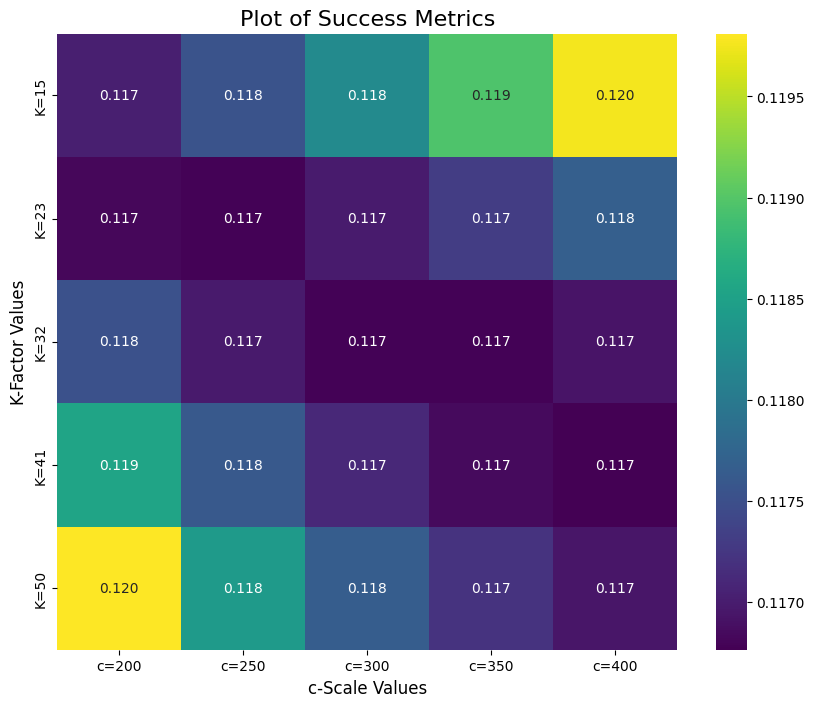

In [308]:
y_labels = [f"K={k}" for k in refined_Ks]

# Do the same for the cs list to create the x-axis labels.
x_labels = [f"c={c}" for c in refined_cs]


# 3. --- Create the Plot (code is the same as before) ---

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    success_metric2s_ref,
    annot=True,
    fmt=".3f",
    cmap='viridis',
    xticklabels=x_labels,
    yticklabels=y_labels
)

plt.title('Plot of Success Metrics', fontsize=16)
plt.ylabel('K-Factor Values', fontsize=12)
plt.xlabel('c-Scale Values', fontsize=12)


# 4. --- Display the Plot ---
plt.show()

In [ ]:
val_keys = [
    'sr_surf_elo_err',
    'sr_ovrl_elo_err',
    'sr_mxed_elo_err',
    'swr_err',
    'rwr_err',
    'swr_err_baseline',
    'rwr_err_baseline'
]

max_matches = 120
for req_matches in range(0, max_matches+10, 10):
    vals = evaluate_metrics(req_matches)

    matches = vals['matches']
    matches_vals[req_matches] = [vals[key]/matches for key in val_keys] + [matches]

index_map = {val_keys[i]: i for i in range(len(val_keys))}
index_map['matches'] = len(val_keys)


print(f"SR SURF Elo Error: {matches_vals[max_matches][index_map['sr_surf_elo_err']]:.2}")
print(f"SR OVRL Elo Error: {matches_vals[max_matches][index_map['sr_ovrl_elo_err']]:.2}")
print(f"SR MXED Elo Error: {matches_vals[max_matches][index_map['sr_mxed_elo_err']]:.2}")

print(f"SR SWR Error: {matches_vals[max_matches][index_map['swr_err']]:.2}")
print(f"SR RWR Error: {matches_vals[max_matches][index_map['rwr_err']]:.2}")

print(f"matches: {vals['matches']}")

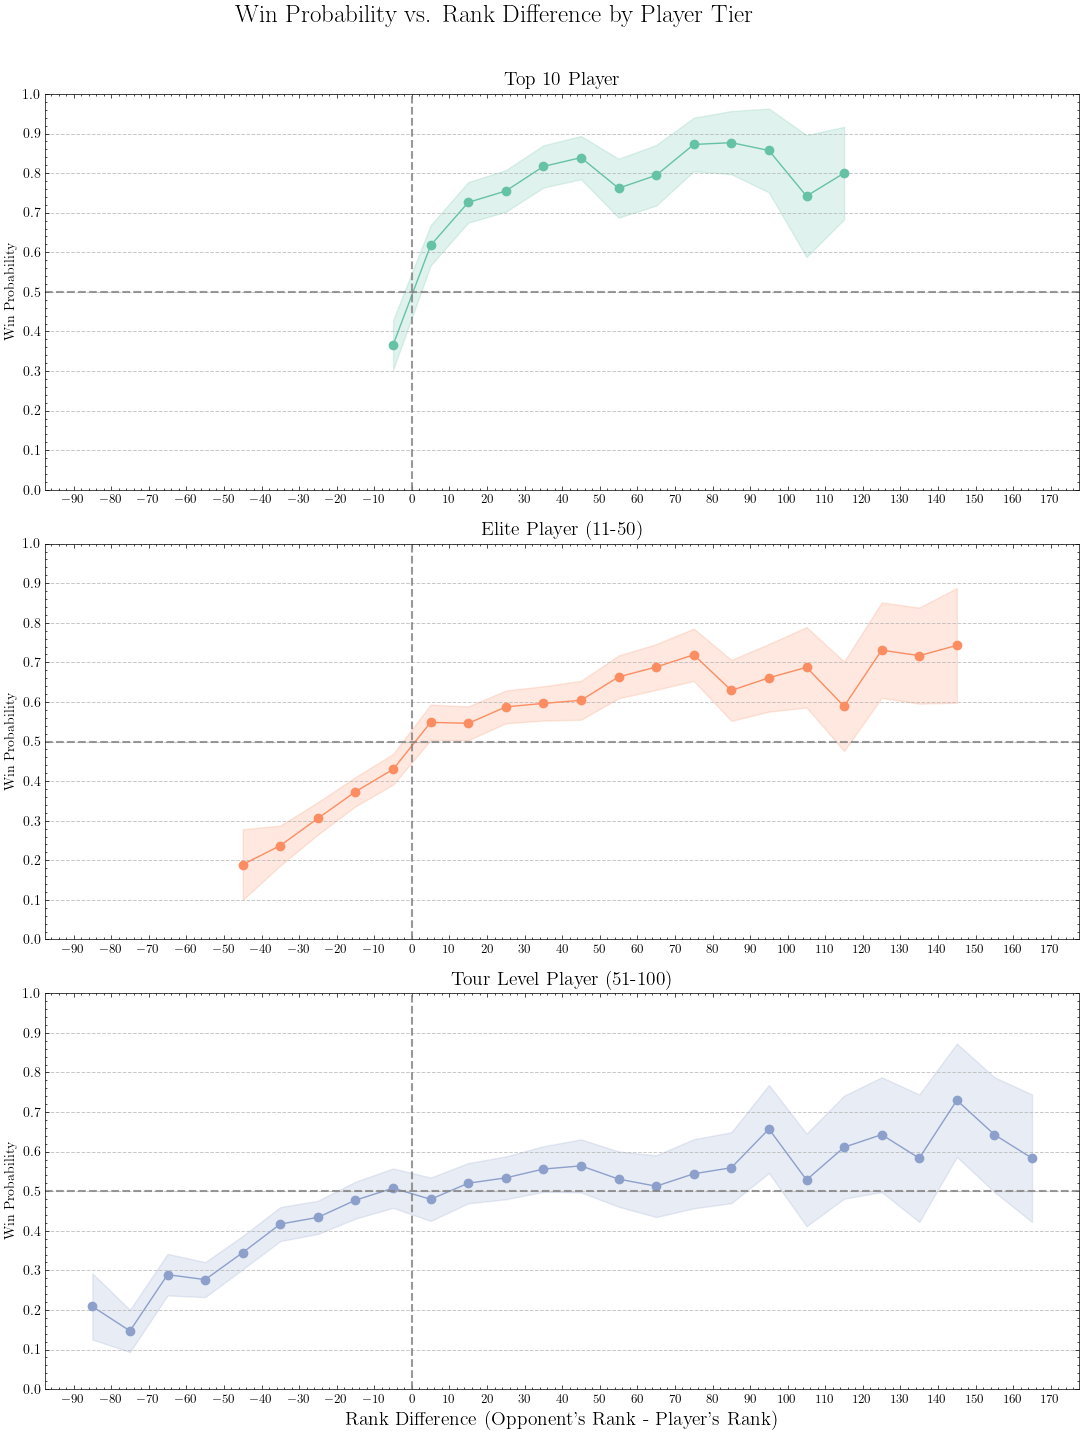

In [13]:

# --- Start of user's original data prep ---
df_cleaned = big_df.dropna(subset=['rank', 'orank']).copy()
df_cleaned = df_cleaned[(df_cleaned['rank'] != '') & (df_cleaned['orank'] != '')]
df_cleaned[['rank', 'orank']] = df_cleaned[['rank', 'orank']].astype(int)

df_p1 = pd.DataFrame({'player_rank': df_cleaned['rank'], 'opponent_rank': df_cleaned['orank'], 'win': df_cleaned['result']})
df_p2 = pd.DataFrame({'player_rank': df_cleaned['orank'], 'opponent_rank': df_cleaned['rank'], 'win': 1-df_cleaned['result']})
doubled_df = pd.concat([df_p1, df_p2], ignore_index=True)
doubled_df['rank_diff'] = doubled_df['opponent_rank'] - doubled_df['player_rank']
# --- End of user's original data prep ---


# --- Define Segments and Bins ---
rank_segments = {
    'Top 10 Player': (doubled_df['player_rank'] <= 10),
    'Elite Player (11-50)': (doubled_df['player_rank'] > 10) & (doubled_df['player_rank'] <= 50),
    'Tour Level Player (51-100)': (doubled_df['player_rank'] > 50) & (doubled_df['player_rank'] <= 100),
}

bin_width = 10
min_bin = int(np.floor(doubled_df['rank_diff'].min() / bin_width)) * bin_width
max_bin = int(np.ceil(doubled_df['rank_diff'].max() / bin_width)) * bin_width
bins = np.arange(min_bin, max_bin + bin_width, bin_width)

doubled_df['rank_diff_bin'] = pd.cut(doubled_df['rank_diff'], bins=bins, right=False)

# --- Create Figure (with shared axes) ---
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True, sharey=True)
segment_names = list(rank_segments.keys())
colors = sns.color_palette("Set2", len(segment_names))

# --- Main Plotting Loop ---
for idx, segment_name in enumerate(segment_names):
    ax = axes[idx]
    segment_condition = rank_segments[segment_name]
    segment_df = doubled_df[segment_condition].copy()

    # --- Calculate Win Probability and Confidence Intervals ---
    # Normal approximation to the binomial distribution for CI
    # SE = sqrt(p(1-p)/n)
    grouped = segment_df.groupby('rank_diff_bin', observed=True)['win'].agg(['mean', 'count'])
    grouped = grouped.rename(columns={'mean': 'win_prob', 'count': 'n_matches'})
    
    # Filter out bins with few matches for statistical stability
    grouped = grouped[grouped['n_matches'] >= 30].copy()
    
    # Calculate 95% CI
    p = grouped['win_prob']
    n = grouped['n_matches']
    z = norm.ppf(0.975) # Z-score for 95% CI
    std_err = np.sqrt(p * (1 - p) / n)
    grouped['ci_low'] = p - z * std_err
    grouped['ci_high'] = p + z * std_err

    # Get the center of each bin for plotting
    bin_centers = [interval.mid for interval in grouped.index]
    
    # --- Plotting the Data ---
    # Plot the main line
    ax.plot(bin_centers, grouped['win_prob'],
            color=colors[idx],
            marker='o',
            linestyle='-',
            label='Win Probability')

    # Plot the confidence interval as a shaded region
    ax.fill_between(bin_centers, grouped['ci_low'], grouped['ci_high'],
                    color=colors[idx],
                    alpha=0.2,
                    label='95% Confidence Interval')

    # --- Formatting for each subplot ---
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_title(segment_name, fontsize=14)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    ax.set_xticks(np.arange(-90, 180, 10))

    # 2. Format the ticks: show labels on all plots and rotate them to prevent overlap
    ax.tick_params(axis='x', labelbottom=True, labelsize=9)
    
    # Format the y-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel("Win Probability", fontsize=10, x=0.06)


# --- Final Figure Formatting ---
# Set shared Y-axis limits
axes[0].set_ylim(0, 1)

# Set shared axis labels and overall title
axes[-1].set_xlabel("Rank Difference (Opponent's Rank - Player's Rank)", fontsize=14)
fig.suptitle("Win Probability vs. Rank Difference by Player Tier", fontsize=18, y=0.96)


# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0.08, 0, 1, 0.95]) # Adjust rect to make space for sup-elements
plt.show()

In [7]:
print(min_bin, max_bin)

-1670 1670


In [ ]:
# players = [n for n,v in player_progresses.items()]
# for player in players:
#     p_df = big_df[(big_df['formatted_player'] == player) | (big_df['formatted_opp'] == player)]
#     last_match = p_df.iloc[-1]
#     home_away = 'home' if last_match['formatted_player'] == player else 'away'
#     last_opp = last_match['formatted_opp'] if home_away == 'home' else last_match['formatted_player']
#     for surf in ['g', 'h', 'c', 'o']:
#         p_df.loc[p_df.index[-1], f'oR_{surf}_s'] = opp_match[f'R_{surf}_s']
#         p_df.loc[p_df.index[-1], f'oR_{surf}_r'] = opp_match[f'R_{surf}_r']
#         p_df.loc[p_df.index[-1], f'oR_{surf}_o'] = opp_match[f'R_{surf}_o']
#     pd.to_pickle(p_df, f'{df_root_dir}/{player}.pkl')

In [ ]:
# backup_df()
original_big_df = pd.read_pickle(big_df_name)
original_R_g_s = original_big_df['R_g_s']
new_R_g_s = big_df['R_g_s']
# assert np.allclose(original_R_g_s, new_R_g_s, atol=150), "R_g_s values have changed after Elo update."
big_df[np.abs(big_df['R_g_s'] - original_R_g_s) > 140]
pd.to_pickle(big_df, big_df_name)
backup_df()
save_df()

In [ ]:
alcaraz_df = big_df[(big_df['formatted_player'] == 'CarlosAlcaraz') | (big_df['formatted_opp'] == 'CarlosAlcaraz')].reset_index()
struff_df = big_df[(big_df['formatted_player'] == 'JanLennardStruff') | (big_df['formatted_opp'] == 'JanLennardStruff')].reset_index()
# alcaraz_R_g_s = alcaraz_df.apply(
#     lambda row: row[['date', 'round', 'R_g_s']] if row['formatted_player'] == 'CarlosAlcaraz' else row[['date', 'round', 'oR_g_s']],
#     axis=1
# ).reset_index(drop=False)
alcaraz_R_g_s_col = alcaraz_df.apply(
    lambda row: pd.Series({
        'R_g_s': row['R_g_s'] if row['formatted_player'] == 'CarlosAlcaraz' else row['oR_g_s'],
        'serve_win_rate': row['serve_win_rate'] if row['formatted_player'] == 'CarlosAlcaraz' else 1-row['return_win_rate']
    }),
    axis=1
)
alcaraz_R_g_s = pd.concat([alcaraz_df[['date', 'round']].reset_index(), alcaraz_R_g_s_col.reset_index()], axis=1)
struff_R_g_r_col = struff_df.apply(
    lambda row: pd.Series({
        'R_g_r': row['R_g_r'] if row['formatted_player'] == 'JanLennardStruff' else row['oR_g_r'],
        'return_win_rate': row['return_win_rate'] if row['formatted_player'] == 'JanLennardStruff' else 1-row['serve_win_rate']
    }),
    axis=1
)
struff_R_g_r = pd.concat([struff_df[['index','date', 'round']], struff_R_g_r_col], axis=1)
alcaraz_R_g_s_trusted = pd.read_pickle(f'{df_root_dir}/CarlosAlcaraz.pkl')[['date', 'round','R_g_s']]
alcaraz_whole_trusted = pd.read_pickle(f'{df_root_dir}/CarlosAlcaraz.pkl')
struff_R_g_r_trusted = pd.read_pickle(f'{df_root_dir}/JanLennardStruff.pkl')[['date', 'round','R_g_r']]
struff_whole_trusted = pd.read_pickle(f'{df_root_dir}/JanLennardStruff.pkl')